In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import json

In [2]:
from mlp import MLP
from fourier_series import normalize_resize_rotate_torch, dst_type_1, normalize_x_f
from plot_results import process_seg, binarize_labels, ToText, plot_results

def load_json(json_file_path):
    with open(json_file_path, 'r') as f:
        contents = json.load(f)
    return contents

def data_to_tensor(data):
    x = torch.tensor(data[:, 0], dtype=torch.float32)
    y = torch.tensor(data[:, 1], dtype=torch.float32)
    return x, y

## Load Model and Normalisation Constants

In [3]:
net = MLP(input_size=10, hidden_layer_size=64, output_size=[2,2,2,2])
checkpoint = torch.load('weights/best_model.pt', map_location=torch.device('cpu'))
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [4]:
normalize = load_json('data/temp_train_norm_constants.json')
normalize['coefficient_means'] = torch.tensor(normalize['coefficient_means'], dtype=torch.float32)[:10]
normalize['coefficient_sds'] = torch.tensor(normalize['coefficient_sds'], dtype=torch.float32)[:10]

## Prepare DXA

In [5]:
# Load DXA data
dxa_midpoints = np.load('data/midpoints/dxa_midpoints.npy')
dxa_labels = load_json('data/labels/dxa_labels.json')

dxa_labels_binary = binarize_labels(dxa_labels)
dxa_x_from_seg, dxa_y_from_seg = data_to_tensor(dxa_midpoints)

x_dxa, z = normalize_resize_rotate_torch(dxa_x_from_seg, dxa_y_from_seg)
dxa_sine_series = dst_type_1(x_dxa)[:10]
dxa_sine_series_normalized = normalize_x_f(dxa_sine_series, normalize)

## Prepare X-Ray

In [6]:
# Load data for X-ray
xray_labels = load_json('data/labels/xray_labels.json')
xray_labels_binary = binarize_labels(xray_labels)

xray_midpoints = np.load('data/midpoints/xray_midpoints.npy')
xray_img_array = np.load('data/images/xray_image.npy')

img_w = xray_img_array.shape[1]
img_h = xray_img_array.shape[0]
xray_x_from_seg, xray_y_from_seg = data_to_tensor(xray_midpoints)
xray_x_from_seg = xray_x_from_seg * torch.tensor(img_w)
xray_y_from_seg = xray_y_from_seg * torch.tensor(img_h)

# Prepare X-ray 2-d curve
x_xray, z = normalize_resize_rotate_torch(xray_x_from_seg, xray_y_from_seg)
xray_sine_series = dst_type_1(x_xray)[:10]
xray_sine_series_normalized = normalize_x_f(xray_sine_series, normalize)

## Prepare MRI

In [7]:
# Load MRI data
mri_labels = load_json('data/labels/mri_labels.json')
mri_labels_binary = binarize_labels(mri_labels)

mri_midpoints = np.load('data/midpoints/mri_midpoints.npy')
mri_x_from_seg, mri_y_from_seg = data_to_tensor(mri_midpoints)

# Trim end of mri segmentation to remove noisy endpoints
mri_trim = [0.1, 0.05]  # trim 10% from start and 5% from end
mri_x_from_seg = mri_x_from_seg[int(len(mri_x_from_seg)* mri_trim[0]):int(len(mri_x_from_seg) - len(mri_x_from_seg) * mri_trim[1])]
mri_y_from_seg = mri_y_from_seg[int(len(mri_y_from_seg)* mri_trim[0]):int(len(mri_y_from_seg) - len(mri_y_from_seg) * mri_trim[1])]

# Prepare MRI 2-d curve
x_mri, z = normalize_resize_rotate_torch(mri_x_from_seg, mri_y_from_seg)
mri_sine_series = dst_type_1(x_mri)[:10]
mri_sine_series_normalized = normalize_x_f(mri_sine_series, normalize)

## Network Input

In [8]:
## Stack sine series into batch
batch_sine_series = torch.stack([dxa_sine_series_normalized, xray_sine_series_normalized, mri_sine_series_normalized])

net.eval()
with torch.no_grad():
    net_output = net(batch_sine_series)

scoliosis = F.softmax(net_output[0].squeeze(0), dim=1)
n_curves = F.softmax(net_output[1], dim=1)
largest_direction = F.softmax(net_output[2], dim=1)
largest_location = F.softmax(net_output[3], dim=1)

pred_scoliosis = scoliosis.argmax(dim=1)
pred_n_curves = n_curves.argmax(dim=1)
pred_direction = largest_direction.argmax(dim=1)
pred_location = largest_location.argmax(dim=1)


## Plot Predictions

In [9]:
tasks=["Scoliosis", "No. Curves", "Direction", "Location"]
to_text = ToText()

### DXA Predictions

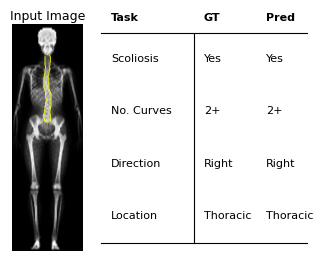

In [10]:
dxa_img = np.load('data/images/dxa_image.npy')
dxa_seg = process_seg(np.load('data/segmentations/dxa_segmentation.npy'))

# Convert binary predictions and labels back to text
dxa_labels_str, dxa_preds_str = to_text.decode(
    list(dxa_labels_binary.values()),
    [pred_scoliosis[0], pred_n_curves[0], pred_direction[0], pred_location[0]])

plot_results(dxa_img, dxa_seg, gt_labels=dxa_labels_str, pred_labels=dxa_preds_str, tasks=tasks)

### X-Ray Predictions

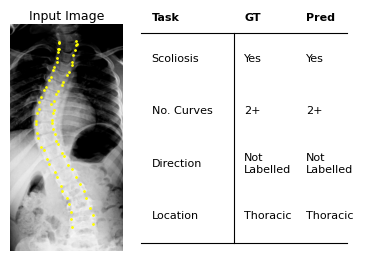

In [11]:
xray_img = np.load('data/images/xray_image.npy')
xray_seg = np.load('data/segmentations/xray_segmentation.npy')

# Convert binary predictions and labels back to text
xray_labels_str, xray_preds_str = to_text.decode(
    list(xray_labels_binary.values()),
    [pred_scoliosis[1], pred_n_curves[1], pred_direction[1], pred_location[1]],
    xray=True)
plot_results(xray_img, xray_seg, gt_labels=xray_labels_str, pred_labels=xray_preds_str, tasks=tasks, modality='xray')

### MRI Predictions

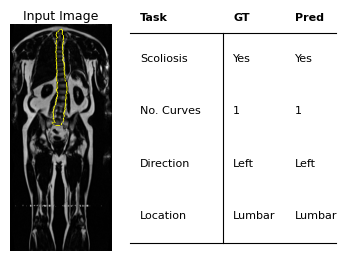

In [12]:
mri_img = np.load('data/images/mri_image.npy')
mri_seg = process_seg(np.load('data/segmentations/mri_segmentation.npy'))

mri_labels_str, mri_preds_str = to_text.decode(list(mri_labels_binary.values()),
                                       [pred_scoliosis[2], pred_n_curves[2], pred_direction[2], pred_location[2]])
plot_results(mri_img, mri_seg, gt_labels=mri_labels_str, pred_labels=mri_preds_str, tasks=tasks)